In [1]:
import torch
from IPython.display import display, Latex
import sympy as sy
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler, random_split
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt
# assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Exercise 19.10
Note here, the matrix is transposed to save space. 

In [7]:
# define symbols
f11, f12, f13, f21, f22, f23, f31, f32, f33 = sy.symbols('f_{11}, f_{12}, f_{13}, f_{21}, f_{22}, f_{23}, f_{31}, f_{32}, f_{33}')
# first row
first_row = np.array([f11, f12, f13, 0, 0, 0, f21, f22, f23, 0, 0, 0, f31, f32, f33])

N = 36 - first_row.size
zeros = np.zeros(N)

first_row = np.concatenate((first_row, zeros))

W = np.zeros((16, 36)).astype(object)
W[0] = first_row
row = first_row.copy()

for i in range(1, 16):
    row = np.roll(row, 3) 
    W[i] = row

# convert to sympy matrix and display
W = sy.Matrix(W.T)
display(Latex(sy.latex(W)))

<IPython.core.display.Latex object>

## Exercise 19.11

We now calculate the output of a convolutional layer when we have stride $s\geq 1$, an image of size $h\times k$ and a filter of size $k\times k$. 
Notice that we cannot move side to side. 
This is because the filter and the image have the same column dimension. 
But we can move up and down.
There will be $\ell$ output dimensions where $k + s(\ell - 1) = h $.
The plus 1 is to assure there is never a zero dimensional output.  
\begin{align*}
\ell = (h - k) /s + 1
\end{align*}
is the output dimension for the rows. Notice here we are assuming that $h-k$ is perfectly divided by $s$, if this is not the case, then we apply the floor function so that
\begin{align*}
\ell =\left\lfloor \frac{h-k}{s} \right\rfloor + 1
\end{align*}
In this situatin we will have a
\begin{align*}
 \left(\left\lfloor \frac{h-k}{s} \right\rfloor + 1\right) \times (1)
\end{align*}
output. 
Now, if the column dimesion is $m$ instead of $k$, then the same argument shows that the output dimesion will be
\begin{align*}
 \left(\left\lfloor \frac{h-k}{s} \right\rfloor + 1\right) \times \left(\left\lfloor \frac{m-k}{s} \right\rfloor + 1\right).
\end{align*}

## Exercise 19.12
We know train a convolutional neural network on the CIFAR10 dataset.

In [3]:
# classes inside dataset
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

def download_dataset(shuffle=True):

    # Normalize data and transform it to a tensor
    transform = transforms.Compose(
                                    [transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                   )


    # get train data
    train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
    # get test data
    test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)
    # get test and validation data using a random split
    test_data, validation_data = random_split(test_data, [5000, 5000], generator=torch.Generator().manual_seed(42))

    # split data into batches
    train_loader = DataLoader(train_data, batch_size=32, shuffle=shuffle)
    validation_loader = DataLoader(validation_data, batch_size=1, shuffle=shuffle)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=shuffle)

    return train_loader, validation_loader, test_loader 



In [4]:
train_loader, validation_loader, test_loader = download_dataset()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class ConvolutionModel(nn.Module):

    def __init__(self):
        super(ConvolutionModel, self).__init__()

        # first convolutional layer
        # num of features: (3*5*5+1)*6 = 550
        # output size: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # relu activation function
        # preserves size
        self.relu = nn.ReLU()

        # maxpool layer
        # num of features: 0
        # output size: 6x14x14
        self.maxpool = nn.MaxPool2d(kernel_size=2) 

        # second convolutional layer
        # num of features: (6*3*3+1)*10 = 550
        # output size: 10x12x12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)

        # third convolutional layer
        # num of features: (10*2*2 +1)*14 = 574
        # output size: 14x11x11
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=14, kernel_size=2)


        # first linear layer
        # num of features (14*11*11 +1)*29 = 49,155
        # outputsize = 1x35
        self.linear1 = nn.Linear(in_features=14 * 11 * 11, out_features=29)
        # second linear layer
        # num of features (35 + 1)*10 = 360
        # outputisze = 1x10
        self.linear2 = nn.Linear(in_features = 29, out_features = 10)

        # flattens before applying linear layer1        
        self.flatten = nn.Flatten()


    # call the layers on an image
    def forward(self, x):
        output = self.relu(self.conv1(x))
        output = self.maxpool(output)
        output = self.relu(self.conv2(output))
        output = self.relu(self.conv3(output))
        output = self.flatten(output)
        output = self.linear1(output) 

        return self.linear2(output)

In [6]:
def train_conv_model():
    # instantiate modmel, objective, and optimizer
    model = ConvolutionModel()
    model = model.to(device)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    N = len(train_loader)
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    mean_loss = []
    # now run 10 epochs looping through all training data
    for epoch in range(12):
        model.train()
        # epoch loss list
        loop = tqdm(total=len(train_loader), position = 0)
        epoch_loss = []
        for batch, (x, y_truth) in enumerate(train_loader):
            # get x, labels
            x, y_truth = x.to(device), y_truth.to(device)
            # zero out gradients
            optimizer.zero_grad()
            # run the model
            outputs = model.forward(x)
            # calculate the loss
            loss = objective(outputs, y_truth)
            epoch_loss.append(loss.item())
            # compute the gradients
            loss.backward()
            # optimize and update the weights
            optimizer.step()
            # set loop description and update
            loop.set_description('loss:{:.4f}'.format(loss.item()))
            loop.update()

        # calculate mean loss for that epoch
        mean_loss.append(np.mean(epoch_loss))

        # now we evaluate the accuracy on the train, test, and validation data
        model.eval()
        # get training accuracy
        curr_accuracy = 0
        for batch, (x, y_truth) in enumerate(train_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            out = model.forward(x)
            curr_accuracy += (out.argmax(1) == y_truth).sum().item()
        train_accuracy.append(curr_accuracy / 50000)

        # get validation accuracy
        curr_accuracy = 0
        for batch, (x, y_truth) in enumerate(validation_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            out = model.forward(x)
            curr_accuracy += (torch.argmax(out) == y_truth).sum().item()
        val_accuracy.append(curr_accuracy / 5000)

        # get test accuracy
        curr_accuracy = 0
        for batch, (x, y_truth) in enumerate(test_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            out = model.forward(x)
            curr_accuracy += (torch.argmax(out) == y_truth.sum()).item()
        test_accuracy.append(curr_accuracy / 5000)

    return model, train_accuracy, val_accuracy, test_accuracy, mean_loss, objective, optimizer

In [7]:
model, train_accuracy, val_accuracy, test_accuracy, mean_loss, objective, optimizer = train_conv_model()

loss:1.0060: 100%|██████████| 1563/1563 [01:02<00:00, 25.06it/s]


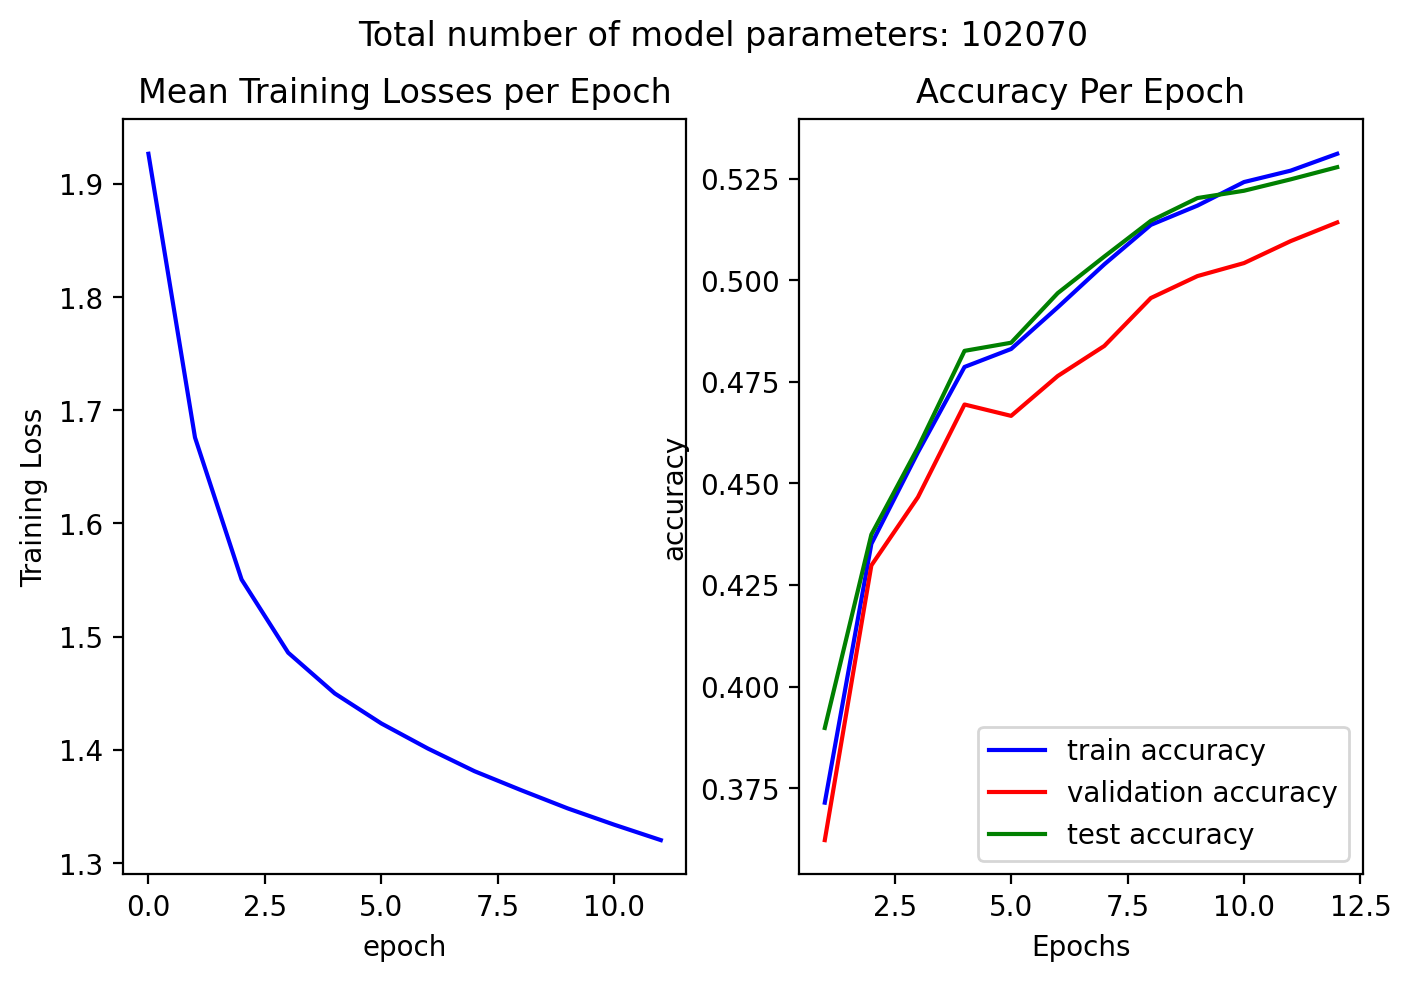

In [22]:
def plot_figures(model, train_accuracy, val_accuracy, test_accuracy, mean_loss):
    num_params = 2*sum(p.numel() for p in model.parameters())
    fig = plt.figure(figsize=(8, 5))
    fig.set_dpi(200)
    ax = fig.add_subplot(121)
    ax.plot(np.arange(12), mean_loss, 'b-')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Mean Training Losses per Epoch')
    ax = fig.add_subplot(122)
    ax.plot(np.arange(1, 13), train_accuracy, 'b-', label='train accuracy')
    ax.plot(np.arange(1, 13), val_accuracy, 'r-', label='validation accuracy')
    ax.plot(np.arange(1, 13), test_accuracy, 'g-', label='test accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('accuracy')
    ax.set_title('Accuracy Per Epoch')
    ax.legend(loc='best')
    plt.suptitle('Total number of model parameters: {}'.format(num_params))
    plt.show()
    return

plot_figures(model, train_accuracy, val_accuracy, test_accuracy, mean_loss)